# import jMF2D

In [1]:
from jMF2D import runDeconvolution, prepare_for_Deconvolution
import pandas as pd
import numpy as np

# read human breast cancer datas

In [3]:
data_dir = "./datasets/breast_cancer/"
sc_data = pd.read_csv(data_dir + "sc.csv", index_col=0)
sp_data = pd.read_csv(data_dir + "sp.csv", index_col=0)
sc_annotation = pd.read_csv(data_dir + "sc_annotation.csv", index_col=0)
sc_annotation = sc_annotation[['celltype_major']]
sp_location = pd.read_csv(data_dir + "/spatial/tissue_positions_list.csv", index_col=0, header=None)

# Align the spots of sp_location with sp_data
sp_location = sp_location.reindex(sp_data.columns)
sp_location = sp_location.iloc[:, [3, 4]]

# prepare data for deconvolution and pre-process

In [3]:
X, Y, L = prepare_for_Deconvolution(sc_data=sc_data, sc_annotation=sc_annotation, sp_data=sp_data, sp_location=sp_location,
                                    filter=False,min_cells=0, max_genes=0, select_hvg=False, construct=True)

## preprocess the scRNA-seq anndata...
## Each celltype contains the number of cells: 
                    PPM1H  SMC5  LINC01140  POMGNT2  ZNF322  ZFAND3  BCL11A  \
annotation                                                                   
B-cells              369   369        369      369     369     369     369   
CAFs                 582   582        582      582     582     582     582   
Cancer Epithelial    894   894        894      894     894     894     894   
Endothelial          217   217        217      217     217     217     217   
Myeloid              684   684        684      684     684     684     684   
Normal Epithelial    735   735        735      735     735     735     735   
PVL                   91    91         91       91      91      91      91   
Plasmablasts          48    48         48       48      48      48      48   
T-cells             4366  4366       4366     4366    4366    4366    4366   

                   ACAD8  MYOF   OXT  ...  DCLK1  KIF

In [ ]:
# save
X.to_csv(data_dir + "X.csv")
Y.to_csv(data_dir + "Y.csv")
pd.DataFrame(data=L).to_csv(data_dir + "L.csv")

# Deconvolution

In [4]:
# parameters
alpha = 1
beta = 1
gamma = 1
loss = 5e-3
max_iter = 1000
seed = 1
initial_B = 1
initial_F = 1
sym = 0
normbyspot = 0

In [5]:
# read the data
X = pd.read_csv(data_dir + "X.csv", index_col=0)
Y = pd.read_csv(data_dir + "Y.csv", index_col=0)
L = pd.read_csv(data_dir + "L.csv", index_col=0).values

In [6]:
# run Deconvolution
F, Z = runDeconvolution(X.values.tolist(), Y.values.tolist(), L.tolist(), alpha, beta, gamma, loss, max_iter,
    seed, initial_B, initial_F, sym, normbyspot)

# find top celltype

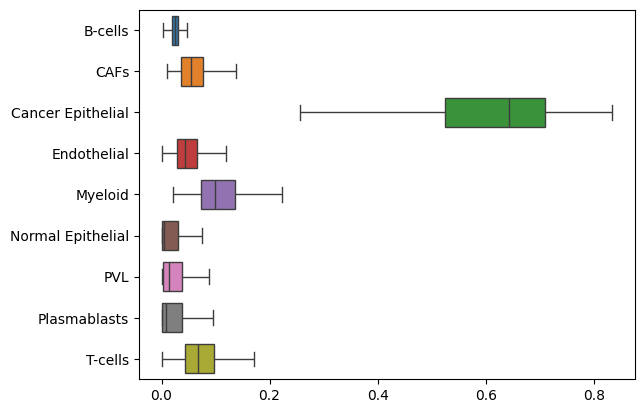

In [7]:
from sklearn.preprocessing import normalize
import seaborn as sns
tisue_annotation = pd.read_csv(data_dir +"metadata.csv",index_col=0)

# jMF2D
norm_F = normalize(F, axis=0, norm='l1')
my = pd.DataFrame(data=norm_F.T,index=X.columns.values,columns=Y.columns.values)
in_tissue = "DCIS"
in_spot = list(tisue_annotation[tisue_annotation['Classification'] == in_tissue].index.values)
data = my.loc[in_spot,:]

ax = sns.boxplot(data=data, orient='h', width=0.7, showfliers=False)

# The significant difference of TOP2 celltypes in the region was calculated

In [8]:
from scipy.stats import mannwhitneyu
(statistic, p_value) = mannwhitneyu(data['Cancer Epithelial'], data['Myeloid'], alternative='two-sided')
print(p_value)

1.4900062893961624e-87


# Significant differences in intra- and out-region cell types

p value:  6.348614390182378e-37


(-0.04, 1.05)

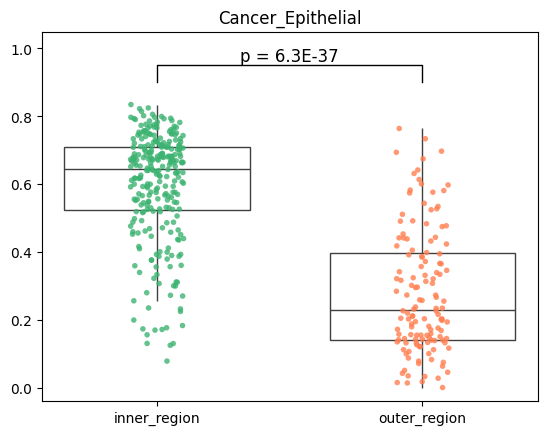

In [9]:
import matplotlib.pyplot as plt
in_tissue = "DCIS"
out_tissue = "Stroma"
celltype = "Cancer Epithelial"
title = "Cancer_Epithelial"
data = my # my / cell2location_res / RCTD_res / spotlight_res / Redeconve_res

out_spot = list(tisue_annotation[tisue_annotation['Classification'] == out_tissue].index.values)
in_spot = list(tisue_annotation[tisue_annotation['Classification'] == in_tissue].index.values)
in_data = list(np.ravel(data.loc[in_spot, celltype].values))
out_data = list(np.ravel(data.loc[out_spot, celltype].values))
(statistic, p_value) = mannwhitneyu(in_data, out_data, alternative='two-sided')
print("p value: ",p_value)
str_p = str('{:e}'.format(p_value))
str_p = str_p[0:3] + "E" + str_p[str_p.find("e")+1:]
out_data += [None] * (len(in_data) - len(out_data))
temp_data = pd.DataFrame({'inner_region': in_data,
                           'outer_region': out_data})
ax = sns.boxplot(data=temp_data, orient='v', width=0.7, showfliers=False, showcaps=False, color='white')
sns.stripplot(data=temp_data, orient='v', alpha=0.8, size=4, palette=sns.color_palette(["#3CB371","#FF7F50"]))
plt.title(title)
y, h = 0.9, 0.05 # 0.8, 0.05
ax.plot([0, 0, 1, 1], [y, y + h, y + h, y], lw=1, c="k")
ax.text(0.5, y + h, "p = " + str_p, ha='center', va='bottom', color="k", size=12)
plt.ylim(-0.04, 1.05)

# Spatial domain identification and HVG detection were further performed

In [15]:
print(sp_location)

                       4     5
AACATTGGTCAGCCGT-1  1361  2511
CATCGAATGGATCTCT-1  1361  2620
CGGGTTGTAGCTTTGG-1  1361  2730
CCTAAGTGTCTAACCG-1  1266  2784
TCTGTGACTGACCGTT-1  1361  2839
...                  ...   ...
TGCAGTGGTAGGGAAC-1  7541  2676
AGCGAGACGTGAAGGC-1  7541  2786
CAGTGTTAATCTCTCA-1  7731  2458
GATCGCTGTGGTGCGT-1  7731  2567
CTCTGCAGGCATTCTT-1  7826  2840

[1162 rows x 2 columns]


In [10]:
import anndata as ad
import cv2
import json
adata = ad.AnnData(X=norm_F.T)  # s*celltype
adata.obs_names = X.columns.values
adata.obs['spot_id'] = X.columns.values
adata.var_names = Y.columns.values
adata.var['celltype'] = Y.columns.values
adata.obs['tissue_annotation'] = tisue_annotation['Classification'].values
adata.obs["y_pixel"] = sp_location[4].values
adata.obs["x_pixel"] = sp_location[5].values
adata.obsm['spatial'] = sp_location[[5, 4]].values
print(adata.obs)

hires = cv2.imread(data_dir + "/spatial/tissue_hires_image.png")
lowres = cv2.imread(data_dir + "spatial/tissue_lowres_image.png")
with open(data_dir + "spatial//scalefactors_json.json", 'r', encoding='utf-8') as f:
    scalefactors = json.load(f)
adata.uns['spatial'] = {"CID44971":
    {
        'images': {'hires': hires, "lowres": lowres},
        'scalefactors': scalefactors
    }}
adata = adata[adata.obs['tissue_annotation']!="Artefact",]
print(adata)

                               spot_id              tissue_annotation  \
AACATTGGTCAGCCGT-1  AACATTGGTCAGCCGT-1  Normal + stroma + lymphocytes   
CATCGAATGGATCTCT-1  CATCGAATGGATCTCT-1  Normal + stroma + lymphocytes   
CGGGTTGTAGCTTTGG-1  CGGGTTGTAGCTTTGG-1  Normal + stroma + lymphocytes   
CCTAAGTGTCTAACCG-1  CCTAAGTGTCTAACCG-1  Normal + stroma + lymphocytes   
TCTGTGACTGACCGTT-1  TCTGTGACTGACCGTT-1  Normal + stroma + lymphocytes   
...                                ...                            ...   
TGCAGTGGTAGGGAAC-1  TGCAGTGGTAGGGAAC-1  Invasive cancer + lymphocytes   
AGCGAGACGTGAAGGC-1  AGCGAGACGTGAAGGC-1  Invasive cancer + lymphocytes   
CAGTGTTAATCTCTCA-1  CAGTGTTAATCTCTCA-1  Invasive cancer + lymphocytes   
GATCGCTGTGGTGCGT-1  GATCGCTGTGGTGCGT-1  Invasive cancer + lymphocytes   
CTCTGCAGGCATTCTT-1  CTCTGCAGGCATTCTT-1  Invasive cancer + lymphocytes   

                    y_pixel  x_pixel  
AACATTGGTCAGCCGT-1     1361     2511  
CATCGAATGGATCTCT-1     1361     2620  
CGGGTT

D:\python\anaconda\envs\jMF2D\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\python\anaconda\envs\jMF2D\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


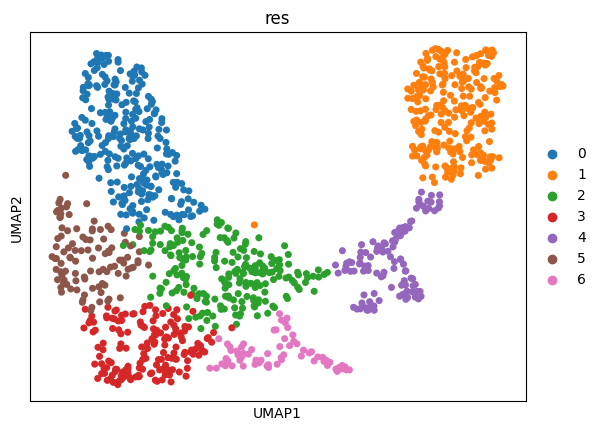

[<Axes: title={'center': 'tissue_annotation'}, xlabel='spatial1', ylabel='spatial2'>]

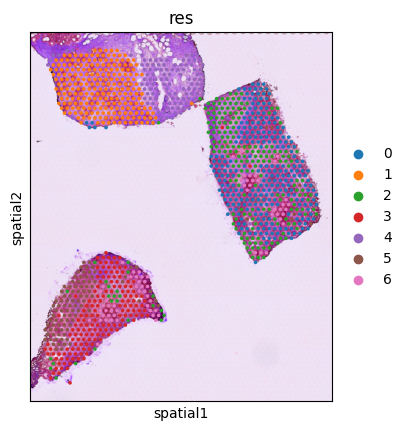

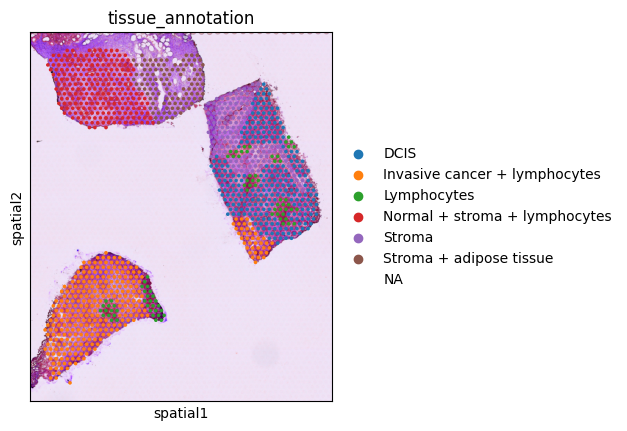

In [11]:
import matplotlib.pyplot as plt
import scanpy as sc
sc.pp.neighbors(adata, n_neighbors=15) 
sc.tl.leiden(adata, key_added="res", resolution=0.35)
sc.tl.umap(adata)
sc.pl.umap(adata, color="res")
sc.pl.spatial(adata, color="res",show=False) 
sc.pl.spatial(adata, color='tissue_annotation', img_key="hires", show=False)

[<Axes: title={'center': 'res'}, xlabel='spatial1', ylabel='spatial2'>]

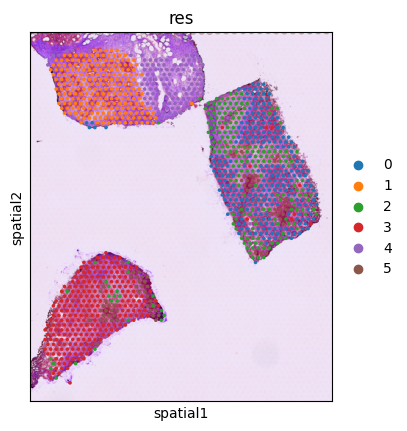

In [12]:
# combine 3 and 5
adata.obs.loc[adata.obs['res'] == '5', 'res'] = '3'
adata.obs.loc[adata.obs['res'] == '6', 'res'] = '5'
adata.obs['res'] = adata.obs['res'].cat.remove_unused_categories()
sc.pl.spatial(adata, color="res",show=False) 

[<Axes: title={'center': 'res'}, xlabel='spatial1', ylabel='spatial2'>]

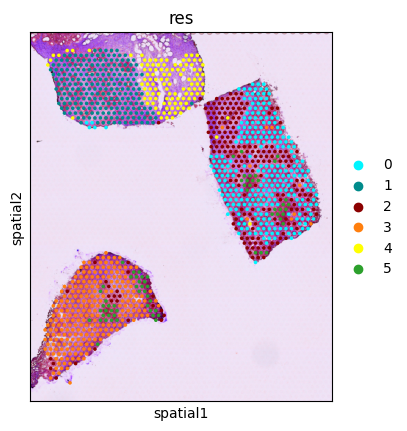

In [13]:
# ['#00F5FF', '#ff7f0e', '#2ca02c', '#008B8B', '#8B0000', '#FFFF00']
adata.uns['res_colors'] = ['#00F5FF', '#008B8B', '#8B0000', '#ff7f0e', '#FFFF00', '#2ca02c']
sc.pl.spatial(adata, color="res",show=False) 

In [14]:
## ARI
from sklearn import metrics
import math
change_dict ={'DCIS':0, 'Invasive cancer + lymphocytes':3, 'Lymphocytes':5, 'Normal + stroma + lymphocytes':1, 
             'Stroma':2, 'Stroma + adipose tissue': 4}
true_label = [change_dict.get(item, item) for item in adata.obs['tissue_annotation'].values]
# filter NA
pre_label = [int(x) for x in adata.obs['res'].values]
filtered_lists = [(x, y) for x, y in zip(true_label, pre_label) if not math.isnan(x)]
true_label, pre_label = zip(*filtered_lists)
ARI = metrics.adjusted_rand_score(true_label, pre_label)
print(ARI)

0.6419670290975734


[<Axes: title={'center': 'res'}, xlabel='spatial1', ylabel='spatial2'>]

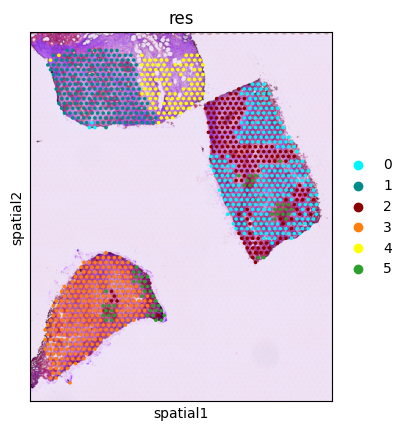

In [15]:
# refined label
adata.obs['res'] = refine_label(adata,key='res',radius=6)
sc.pl.spatial(adata, color="res",show=False) 

In [16]:
## refined ARI
from sklearn import metrics
import math
true_label = [change_dict.get(item, item) for item in adata.obs['tissue_annotation'].values]
pre_label = [int(x) for x in adata.obs['res'].values]
filtered_lists = [(x, y) for x, y in zip(true_label, pre_label) if not math.isnan(x)]
true_label, pre_label = zip(*filtered_lists)
ARI = metrics.adjusted_rand_score(true_label, pre_label)
print(ARI)

0.7301911631621025


# Observe the consistency between the identified regions in domain 0 and the organizational annotations.

D:\python\anaconda\envs\jMF2D\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\12604\AppData\Local\Temp\ipykernel_77404\1425534626.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  in_out_adata.obs['in_out'] = np.where(in_out_adata.obs.index.isin(adata[adata.obs['tissue_annotation']=='DCIS',].obs_names), 0, 1)


4.566037735849057


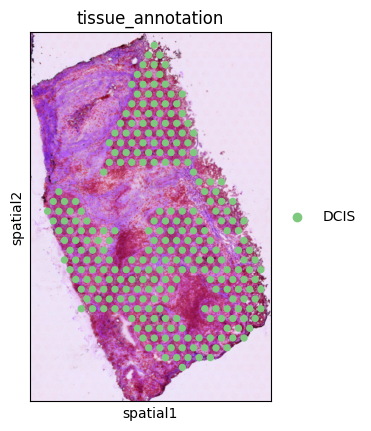

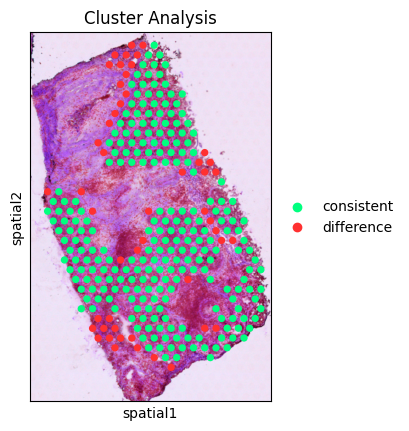

In [17]:
crop_coord = [5450, 7800, 1800, 5400]
sc.pl.spatial(adata[adata.obs['tissue_annotation']=='DCIS',], color='tissue_annotation', img_key="hires", show=False,palette='Accent',
             crop_coord=crop_coord)

import matplotlib.colors as colors 
in_out_adata = adata[adata.obs['res']=='0',]
in_out_adata.obs['in_out'] = np.where(in_out_adata.obs.index.isin(adata[adata.obs['tissue_annotation']=='DCIS',].obs_names), 0, 1)
in_out_adata.obs['in_out'] = in_out_adata.obs['in_out'].map(pd.Series({1:'difference',0:'consistent'})) 
sc.pl.spatial(in_out_adata, color="in_out", show=False,palette=['#00FF7F','#FF3030'],crop_coord=crop_coord)
plt.title("Cluster Analysis")
print(len(in_out_adata[in_out_adata.obs['in_out']=='consistent']) / len(in_out_adata[in_out_adata.obs['in_out']=='difference']))

# Identify region-specific spatial variable genes.

In [18]:
spatial_adata = ad.AnnData(X=sp_data.T)  # spot*gene
spatial_adata.obs_names = sp_data.columns.values
spatial_adata.obs['spot_id'] = sp_data.columns.values
spatial_adata.var_names = sp_data.index.values

# spatial 
spatial_adata.obsm['spatial'] = sp_location[[5, 4]].values
spatial_adata.uns['spatial'] = {"CID44971":
    {
        'images': {'hires': hires, "lowres": lowres},
        'scalefactors': scalefactors
    }}
spatial_adata.obs['tissue_annotation'] = tisue_annotation['Classification'].values
spatial_adata.obs["y_pixel"] = sp_location[4].values
spatial_adata.obs["x_pixel"] = sp_location[5].values


spatial_adata.obs["pred"] = adata.obs['res']
print(spatial_adata.obs)

                               spot_id              tissue_annotation  \
AACATTGGTCAGCCGT-1  AACATTGGTCAGCCGT-1  Normal + stroma + lymphocytes   
CATCGAATGGATCTCT-1  CATCGAATGGATCTCT-1  Normal + stroma + lymphocytes   
CGGGTTGTAGCTTTGG-1  CGGGTTGTAGCTTTGG-1  Normal + stroma + lymphocytes   
CCTAAGTGTCTAACCG-1  CCTAAGTGTCTAACCG-1  Normal + stroma + lymphocytes   
TCTGTGACTGACCGTT-1  TCTGTGACTGACCGTT-1  Normal + stroma + lymphocytes   
...                                ...                            ...   
TGCAGTGGTAGGGAAC-1  TGCAGTGGTAGGGAAC-1  Invasive cancer + lymphocytes   
AGCGAGACGTGAAGGC-1  AGCGAGACGTGAAGGC-1  Invasive cancer + lymphocytes   
CAGTGTTAATCTCTCA-1  CAGTGTTAATCTCTCA-1  Invasive cancer + lymphocytes   
GATCGCTGTGGTGCGT-1  GATCGCTGTGGTGCGT-1  Invasive cancer + lymphocytes   
CTCTGCAGGCATTCTT-1  CTCTGCAGGCATTCTT-1  Invasive cancer + lymphocytes   

                    y_pixel  x_pixel pred  
AACATTGGTCAGCCGT-1     1361     2511    1  
CATCGAATGGATCTCT-1     1361     262

In [19]:
sc.pp.log1p(spatial_adata)
sc.tl.rank_genes_groups(spatial_adata, groupby='pred', method='wilcoxon')

In [20]:
print(sc.get.rank_genes_groups_df(spatial_adata, group="0"))
print(pd.DataFrame(data=spatial_adata.uns['rank_genes_groups']["pvals_adj"]))
pvals_adj=[i[0] for i in spatial_adata.uns['rank_genes_groups']["pvals_adj"]]
print(pd.DataFrame(data=spatial_adata.uns['rank_genes_groups']["names"]))
genes=[i[0] for i in spatial_adata.uns['rank_genes_groups']["names"]]

         names     scores  logfoldchanges          pvals      pvals_adj
0          MDK  22.946350        2.524487  1.602470e-116  3.082671e-112
1       CYP1B1  21.940372        2.949608  1.070201e-106  1.029372e-102
2        CENPW  21.643612        3.126908  6.981499e-104  4.476770e-100
3        YWHAQ  21.572107        2.435745  3.283867e-103   1.579294e-99
4         FRZB  21.557646        2.873194  4.488638e-103   1.726959e-99
...        ...        ...             ...            ...            ...
19232     XIST  -6.905858       -1.124454   4.990080e-12   3.552708e-11
19233  TNFSF10  -6.948540       -1.428439   3.690866e-12   2.655243e-11
19234      DST  -7.094761       -1.309289   1.295749e-12   9.665112e-12
19235      LTF  -8.719769       -1.616781   2.787685e-18   3.000934e-17
19236     MMP7  -9.463933       -2.222085   2.965728e-21   3.847048e-20

[19237 rows x 5 columns]
                   0             1             2             3             4  \
0      3.082671e-112  4.212020

[<Axes: title={'center': 'MDK'}, xlabel='spatial1', ylabel='spatial2'>]

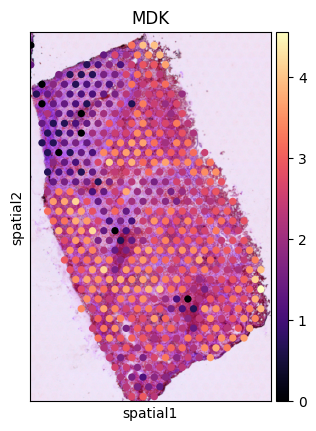

In [21]:
# 'MDK'
sc.pl.spatial(spatial_adata, color="MDK", img_key="hires", show=False, crop_coord=crop_coord, color_map="magma")

[<Axes: title={'center': 'CYP1B1'}, xlabel='spatial1', ylabel='spatial2'>]

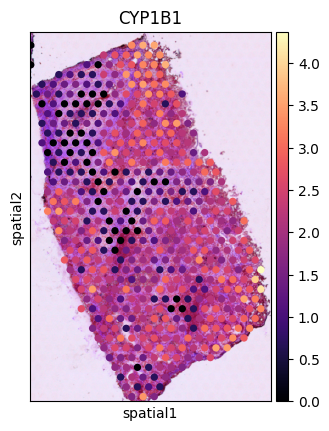

In [22]:
# 'CYP1B1'
sc.pl.spatial(spatial_adata, color="CYP1B1", img_key="hires", show=False, crop_coord=crop_coord, color_map="magma")

[<Axes: title={'center': 'CENPW'}, xlabel='spatial1', ylabel='spatial2'>]

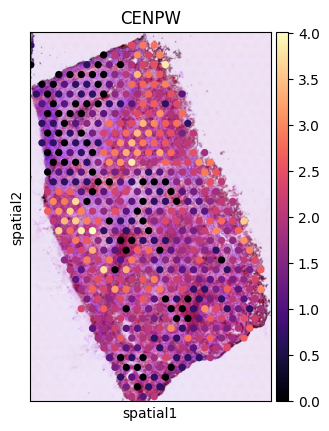

In [23]:
# 'CENPW'
sc.pl.spatial(spatial_adata, color="CENPW", img_key="hires", show=False, crop_coord=crop_coord, color_map="magma")

# Calculate Moran's I and Geary's C to verify the spatial autocorrelation of SVGs.

In [2]:
rank_df = sc.get.rank_genes_groups_df(spatial_adata, group="0")
genes = list(rank_df['names'].values)[0:100]
show_df = spatial_adata.to_df()
show_df = np.exp(show_df) - 1

In [3]:
## Calculate Moran I and Geary_C
gene_exp = show_df[genes]
x = spatial_adata.obs['x_pixel']
y = spatial_adata.obs['y_pixel']
moranI = Moran_I(gene_exp,x,y)
gearyC = Geary_C(gene_exp,x,y)
print("Moran I: \n",moranI)
print("Geary C: \n",gearyC)

Moran I: 
 MDK       0.670156
CYP1B1    0.593911
CENPW     0.575711
YWHAQ     0.580631
FRZB      0.601614
            ...   
SDC1      0.511123
PRSS8     0.411756
RPL27A    0.607149
YWHAE     0.484026
GNPAT     0.468204
Length: 100, dtype: float64
Geary C: 
 MDK       0.309222
CYP1B1    0.352068
CENPW     0.399623
YWHAQ     0.384069
FRZB      0.379501
            ...   
SDC1      0.474634
PRSS8     0.552683
RPL27A    0.361026
YWHAE     0.502156
GNPAT     0.518636
Length: 100, dtype: float64


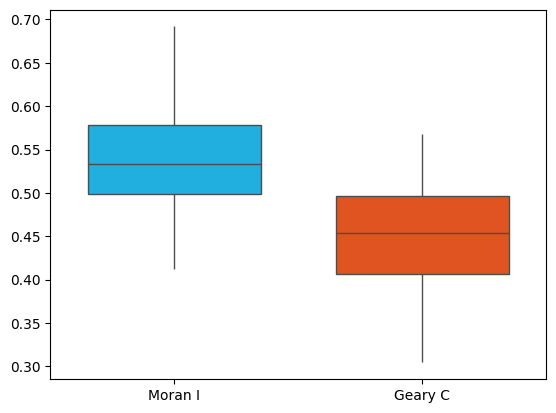

In [5]:
temp_data = pd.DataFrame({'Moran I': moranI,
                               'Geary C': gearyC})
ax = sns.boxplot(data=temp_data, orient='v', width=0.7, showfliers=False, showcaps=False, palette=['deepskyblue','orangered']) # color='white'